# Targeted vs. Untargeted PGD attacks

In this notebook we will experiment with **adversarial evasion attacks**, against a pre-trained model from robustbench. Exploring untargeted and targeted evasion attacks over multiple backends.

Evasion attacks (a.k.a. *adversarial examples*) consists of carefully perturbing
the input samples at *test time* to have them misclassified. An untargeted attack aims to make the classifiers misclassify the crafted input into any incorrect class, while a targeted attack forces it to predict a specific (wrong) class chosen by the attacker.

In [1]:
%%capture --no-stdout
try:
    import secmlt
except ImportError:
   %pip install secml-torch[foolbox,adv_lib]

#### Testing a Pre-trained Model on Clean Inputs
We will first load a pretrained classifier from robustbench, evaluating its performance in the standard scenario, *i.e. not under attack*.

In [2]:
%%capture
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from robustbench.utils import load_model
from secmlt.metrics.classification import Accuracy, AttackSuccessRate
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from torch.utils.data import DataLoader, Subset

In [ ]:
%%capture
#Loading a pretrained model
net = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

#setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)
net.eval()

transform = transforms.Compose([transforms.ToTensor()])

#loading the CIFAR10 Dataset
dataset_path = "data/datasets/"
num_samples = 5
test_dataset = torchvision.datasets.CIFAR10(
    transform=transform,
    train=False,
    root=dataset_path,
    download=True,
)
test_dataset = Subset(test_dataset, list(range(num_samples)))
test_data_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

cifar10_labels = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}



In [4]:
# Wrap model
model = BasePytorchClassifier(net, preprocessing=transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))

# Test accuracy on original data
accuracy = Accuracy()(model, test_data_loader)
print("Testing the pretrained native model - Accuracy:", accuracy.item())

Testing the pretrained native model - Accuracy: 1.0


#### Instantiating Untargeted PGD Attack over Multiple Backends

Untargeted attacks refer to the case in which the attacker is satisfied with producing a generic misclassification (e.g., an airplane will be recognized as anything else but an airplane) and can be written as:

$$
\max_{\delta} L(x + \delta, y; \theta) \quad \text{s.t.} \quad \|\delta\|_p \leq \epsilon \quad \text{subject to} \quad l_b \preceq x + \delta \preceq l_u
$$

where  $L$ is the objective function of our attack (it defines the goal of the attacker, i.e., where to find adversarial examples), $x$ is the sample to perturb, $y$ is the true label, $\theta$ are the parameters of the model,  $\epsilon$ is the maximum allowed perturbation, $l_b$ and $l_u$ are the input-space bounds (for instance, images must be clipped in 0-1 or 0-255 to be valid samples) {cite:t}`biggio2013evasion`.


Now, we are going to create multiple untargeted attacks against the previous loaded pre-trained model, using the **projected gradient descent (PGD)** algorithm proposed in {cite:t}`madry2018towards`.


Which is implemented in SecML-Torch by the `PGD` class.

Let's define the attack parameters. First, we choose to generate an $l_∞$
perturbation within a maximum ball of radius `epsilon = 0.1` from the initial
point. The attack runs for `num_step = 10` iterations, with a `step_size = 0.02` per iteration. Since we are not targeting a specific class, we set `y_target = None` to perform an untargeted attack. Random initialization is disabled with `random_start = False`.
Finally, we instantiate the PGD attack using three different backends:

  - `NATIVE`: runs the attack using the internal PyTorch-based implementation provided by SecML-Torch.
  - `FOOLBOX`: leverages the Foolbox library, a standard external framework for adversarial robustness evaluation.
  - `ADVLIB`: uses the advlib backend, which allows integration with additional loss functions such as DLR.

Multiple backends offer flexibility, performance options, and implementation cross-checks.

In [5]:
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.evasion.pgd import PGD

In [6]:
# Create and run attack
epsilon = 0.1
num_steps = 5
step_size = 0.02
perturbation_model = LpPerturbationModels.LINF
y_target = None
native_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    y_target=y_target,
    backend=Backends.NATIVE,
)
native_adv_ds_u = native_attack(model, test_data_loader)

# Test accuracy on adversarial examples
n_robust_accuracy = Accuracy()(model, native_adv_ds_u)
print("Robust Accuracy (PGD Native): ", n_robust_accuracy.item())

# Create and run attack
foolbox_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    y_target=y_target,
    backend=Backends.FOOLBOX,
)
f_adv_ds_u = foolbox_attack(model, test_data_loader)

# Test accuracy on adversarial examples
f_robust_accuracy = Accuracy()(model, f_adv_ds_u)
print("Robust Accuracy (PGD Foolbox): ", f_robust_accuracy.item())

# Create and run attack
advlib_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    loss_function="ce",
    y_target=y_target,
    backend=Backends.ADVLIB,
)
al_adv_ds_u = advlib_attack(model, test_data_loader)

# Test accuracy on adversarial examples
al_robust_accuracy = Accuracy()(model, al_adv_ds_u)
print("Robust Accuracy (PGD AdvLib): ", al_robust_accuracy.item())

Robust Accuracy (PGD Native):  0.0
Robust Accuracy (PGD Foolbox):  0.20000000298023224
Robust Accuracy (PGD AdvLib):  0.0


#### Instantiating Targeted PGD Attack over Multiple Backends

Targeted attacks refer to the case in which the attacker wants to produce a specific misclassification (e.g, a ship must be recognized as a dog) and can be written as:

$$
\min_{\delta} L(x + \delta, y_t; \theta) \quad \text{s.t.} \quad \|\delta\|_p \leq \epsilon \quad \text{subject to} \quad l_b \preceq x + \delta \preceq l_u
$$

where we change the maximization to a minimization, since we want to minimize the error of the classifier w.r.t. the tarbet label $y_t$.

In this experiment with respect to the previous one, we are simply setting the target label `y_target = 5`,  corresponding to a dog.

In [7]:
# Create and run attack
epsilon = 0.2
num_steps = 10
step_size = 0.02
perturbation_model = LpPerturbationModels.LINF
y_target = 5
native_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    y_target=y_target,
    backend=Backends.NATIVE,
)
native_adv_ds_t = native_attack(model, test_data_loader)

# Test attack success rate on adversarial examples
n_robust_accuracy = AttackSuccessRate(y_target=y_target)(model, native_adv_ds_t)
print("ASR (PGD Native): ", n_robust_accuracy.item())

# Create and run attack
foolbox_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    y_target=y_target,
    backend=Backends.FOOLBOX,
)
f_adv_ds_t = foolbox_attack(model, test_data_loader)

# Test attack success rate on adversarial examples
f_robust_accuracy = AttackSuccessRate(y_target=y_target)(model, f_adv_ds_t)
print("ASR (PGD Foolbox): ", f_robust_accuracy.item())

# Create and run attack
advlib_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    loss_function="ce",
    y_target=y_target,
    backend=Backends.ADVLIB,
)
al_adv_ds_t = advlib_attack(model, test_data_loader)

# Test attack success rate on adversarial examples
al_robust_accuracy = AttackSuccessRate(y_target=y_target)(model, al_adv_ds_t)
print("ASR (PGD AdvLib): ", al_robust_accuracy.item())

ASR (PGD Native):  1.0
ASR (PGD Foolbox):  0.20000000298023224
ASR (PGD AdvLib):  1.0


#### Visualizing Adversarial Perturbation

We now visualize the adversarial perturbations applied by each backend on the third sample from the test set, in the target attack scenario.
This comparison helps illustrate both the effectiveness and visual effect of the attacks.

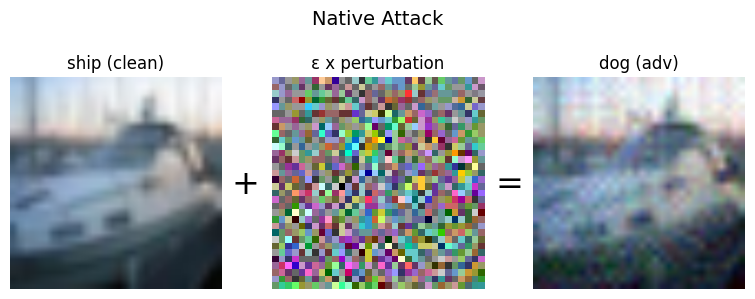

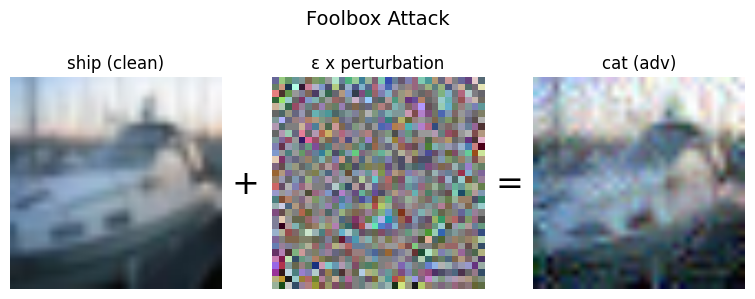

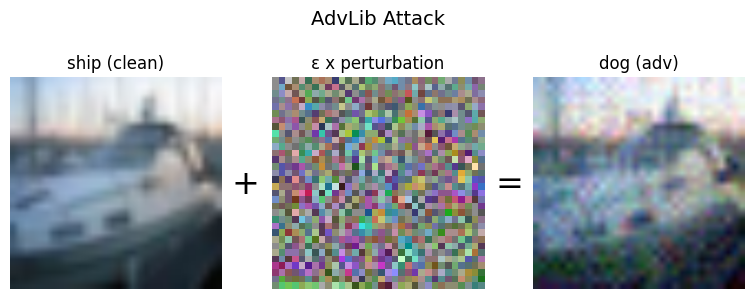

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Resize

perturbed_datasets = {"Native":native_adv_ds_t, "Foolbox":f_adv_ds_t, "AdvLib":al_adv_ds_t}
results = {}

# Selects the third sample from the original dataset and each adversarial dataset
# Stores the original/adversarial tensors and their predicted class labels
for name, adv_ds in perturbed_datasets.items():
  xs_orig, ys_true = next(iter(test_data_loader))
  x_orig, y_true = xs_orig[2].unsqueeze(0), ys_true[2]
  orig_label = cifar10_labels[model.predict(x_orig).item()]

  xs_adv, ys_true = next(iter(adv_ds))
  x_adv, y_true = xs_adv[2].unsqueeze(0)    , ys_true[2]
  adv_label = cifar10_labels[model.predict(x_adv).item()]

  results[name] = {
          "orig_tensor": x_orig,
          "adv_tensor":  x_adv,
          "orig_label":  orig_label,
          "adv_label":   adv_label
      }

def to_numpy_rescaled(img_tensor, scale=8):
    to_pil = ToPILImage()
    img_pil = to_pil(img_tensor.cpu().detach())
    img_pil = Resize((img_pil.size[1]*scale, img_pil.size[0]*scale))(img_pil)
    return np.array(img_pil)


def plot_adversarial_example(start_tensor, adv_tensor,
                             orig_label=None, adv_label=None,
                             attack_name=None,
                             figsize=(8, 3), upscale_factor=8):
    """
    Plot original image, amplified perturbation, and adversarial image side by side,
    with the attack name as a figure title.
    Images are upscaled for clarity.
    """
    # Get tensors in shape [C, H, W]
    if start_tensor.ndim == 4:
        start_tensor = start_tensor[0]
    if adv_tensor.ndim == 4:
        adv_tensor = adv_tensor[0]

    # Convert and upscale
    orig_img = to_numpy_rescaled(start_tensor, upscale_factor)
    adv_img = to_numpy_rescaled(adv_tensor, upscale_factor)

    # Compute and upscale perturbation
    perturb = (start_tensor - adv_tensor).cpu().detach().numpy()
    perturb -= perturb.min()
    if perturb.max() > 0:
        perturb /= perturb.max()
    perturb = np.transpose(perturb, (1, 2, 0))  # C×H×W → H×W×C
    perturb = np.array(perturb)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.text(0.335, 0.4, "+", fontsize=24, ha='center', va='center')
    fig.text(0.665, 0.4, "=", fontsize=24, ha='center', va='center')
    if attack_name:
        fig.suptitle(attack_name, fontsize=14)

    axes[0].imshow(orig_img)
    axes[0].set_title(orig_label or "Original")
    axes[0].axis('off')

    axes[1].imshow(perturb)
    axes[1].set_title("ε x perturbation")
    axes[1].axis('off')

    axes[2].imshow(adv_img)
    axes[2].set_title(adv_label or "Adversarial")
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

#Plot all at the end
for name, data in results.items():
    plot_adversarial_example(
        start_tensor=data["orig_tensor"],
        adv_tensor=data["adv_tensor"],
        orig_label=f"{data['orig_label']} (clean)",
        adv_label=f"{data['adv_label']} (adv)",
        attack_name=f"{name} Attack"
    )

```{bibliography}
:filter: docname in docnames
```